# Haar OpenCV Face Detect

Kevin Walchko, 7 Dec 2016

-----------

In [11]:
%matplotlib inline

In [12]:
from __future__ import print_function
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
import cv2
from math import sqrt

Object Detection using Haar feature-based cascade classifiers is an effective object detection method proposed by Paul Viola and Michael Jones in their paper, "Rapid Object Detection using a Boosted Cascade of Simple Features" in 2001. It is a machine learning based approach where a cascade function is trained from a lot of positive (faces in the image) and negative images (no faces in the image). It is then used to detect objects (faces in this case) in other images.


## Basics of how it works (remove this section, go with the shorter one below)

Here we will work with face detection. Initially, the algorithm needs a lot of positive images and negative images to train the classifier. Then we need to extract features from it. For this, haar features are a convolutional kernel to be applied to an image. Each feature is a single value obtained by subtracting sum of pixels under white rectangle from sum of pixels under black rectangle.

$$
feature = \sum{pixel_{white}} - \sum{pixel_{black}}
$$

![](haar_features.jpg)

Now all possible sizes and locations of each kernel is used to calculate plenty of features. (Just imagine how much computation it needs? Even a 24x24 window results over 160000 features). For each feature calculation, we need to find sum of pixels under white and black rectangles. To solve this, they introduced the integral images. It simplifies calculation of sum of pixels, how large may be the number of pixels, to an operation involving just four pixels. Nice, isn't it? It makes things super-fast.

But among all these features we calculated, most of them are irrelevant. For example, consider the image below. Top row shows two good features. The first feature selected seems to focus on the property that the region of the eyes is often darker than the region of the nose and cheeks. The second feature selected relies on the property that the eyes are darker than the bridge of the nose. But the same windows applying on cheeks or any other place is irrelevant. So how do we select the best features out of 160000+ features? It is achieved by [Adaboost](https://en.wikipedia.org/wiki/AdaBoost).

AdaBoost, short for "Adaptive Boosting", is a machine learning meta-algorithm formulated by Yoav Freund and Robert Schapire who won the Gödel Prize in 2003 for their work. It can be used in conjunction with many other types of learning algorithms to improve their performance.

![](haar.png)

For this, we apply each and every feature on all the training images. For each feature, it finds the best threshold which will classify the faces to positive and negative. But obviously, there will be errors or misclassifications. We select the features with minimum error rate, which means they are the features that best classifies the face and non-face images. (The process is not as simple as this. Each image is given an equal weight in the beginning. After each classification, weights of misclassified images are increased. Then again same process is done. New error rates are calculated. Also new weights. The process is continued until required accuracy or error rate is achieved or required number of features are found).

Final classifier is a weighted sum of these weak classifiers. It is called weak because it alone can't classify the image, but together with others forms a strong classifier. The paper says even 200 features provide detection with 95% accuracy. Their final setup had around 6000 features. (Imagine a reduction from 160000+ features to 6000 features. That is a big gain).

So now you take an image. Take each 24x24 window. Apply 6000 features to it. Check if it is face or not. Wow.. Wow.. Isn't it a little inefficient and time consuming? Yes, it is. Authors have a good solution for that.

In an image, most of the image region is non-face region. So it is a better idea to have a simple method to check if a window is not a face region. If it is not, discard it in a single shot. Don't process it again. Instead focus on region where there can be a face. This way, we can find more time to check a possible face region.

For this they introduced the concept of Cascade of Classifiers. Instead of applying all the 6000 features on a window, group the features into different stages of classifiers and apply one-by-one. (Normally first few stages will contain very less number of features). If a window fails the first stage, discard it. We don't consider remaining features on it. If it passes, apply the second stage of features and continue the process. The window which passes all stages is a face region. How is the plan !!!

----

# Face Detector

The algorithm has four stages:

1. Haar Feature Selection
1. Creating an Integral Image
1. Adaboost Training
1. Cascading Classifiers

## Haar Features

All human faces share some similar properties. These regularities may be matched using Haar Features. A few properties common to human faces:

- The eye region is darker than the upper-cheeks.
- The nose bridge region is brighter than the eyes.

Composition of properties forming matchable facial features:

- Location and size: eyes, mouth, bridge of nose
- Value: oriented gradients of pixel intensities: $feature = \sum{pixel_{white}} - \sum{pixel_{black}}$

The four features matched by this algorithm are then sought in the image of a face.

![](haar_features.jpg)
![](haar.png)

## Integral Image

An image representation called the integral image evaluates rectangular features in constant time, which gives them a considerable speed advantage over more sophisticated alternative features. Because each feature's rectangular area is always adjacent to at least one other rectangle, it follows that:

- any two-rectangle feature can be computed in six array references
- any three-rectangle feature in eight
- any four-rectangle feature in nine.

## Adaboost

[Adaboost](https://en.wikipedia.org/wiki/AdaBoost), short for "Adaptive Boosting", is a machine learning meta-algorithm formulated by Yoav Freund and Robert Schapire who won the Gödel Prize in 2003 for their work. It can be used in conjunction with many other types of learning algorithms to improve their performance.

## Cascade Architecture

Since most of the area of an images does not contain a face, you want to use simple, fast deterectors to see if the posibility of a face exists. Thus, a cascade of gradually more complex classifiers achieves even better detection rates and quickly eliminates images without faces.

# Game of Thrones

Ok, let's get some good images to play with and see if we can detect things.

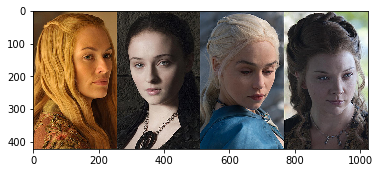

In [13]:
image = cv2.imread('face_pics/got3.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # pretty images
plt.imshow(image);

Here we will deal with detection. OpenCV already contains many pre-trained classifiers for face, eyes, smile etc. Those [XML](https://en.|wikipedia.org/wiki/XML) (extended markup language) files are stored in `??` folder. Let's create face a detector with OpenCV.

First we need to load the required XML classifiers. Then load our input image (or video) in grayscale mode.

In [18]:
# convert our image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# load the haar face detector for the front
faceCascade = cv2.CascadeClassifier('face_pics/haarcascade_frontalface_default.xml')

The next step is to detect faces in our image. The `cv2.CascadeClassifier.detectMultiScale` function is used to detect faces and after computation, it returns a numpy array where the co-ordinates of the faces in the image are stored. The function is called detectMultiScale because it can detect objects at multiple scales. After each level the classifier will resize the image based on the scale provided to detect the object. If the number of levels that the cascade is trained for are exhausted, then the object is not detected. The signature of the function is:

`cv2.CascadeClassifier.detectMultiScale(image, rejectLevels, levelWeights[, scaleFactor[, minNeighbors[, flags[, minSize[, maxSize[, outputRejectLevels]]]]]])`

Here,
- image – Matrix of the type CV_8U containing an image where objects are detected.
- objects – Vector of rectangles where each rectangle contains the detected object.
- scaleFactor – Parameter specifying how much the image size is reduced at each image scale.
- minNeighbors – Parameter specifying how many neighbors each candidate rectangle should have to retain it.
- flags – Parameter with the same meaning for an old cascade as in the function cvHaarDetectObjects. It is not used for a new cascade.
- minSize – Minimum possible object size. Objects smaller than that are ignored.
- maxSize – Maximum possible object size. Objects larger than that are ignored.

Faces found: 4


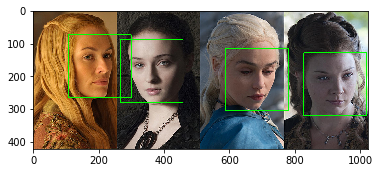

In [17]:
faces = faceCascade.detectMultiScale(
    gray,
    scaleFactor=2,
    minNeighbors=2,
    minSize=(30, 30)
    #flags = cv2.CV_HAAR_SCALE_IMAGE
)

print('Faces found: {}'.format(len(faces)))

# make a copy of the image to draw on
tmp = image.copy()
for (x, y, w, h) in faces:
#     center = (int(x+w/2),int(y+h/2))
#     radius = int(sqrt((w/2)**2+(h/2)**2))
#     cv2.circle(tmp, center, radius, (0, 255, 0), 5)
    cv2.rectangle(tmp, (x, y), (x+w, y+h), (0, 255, 0), 2)

plt.imshow(tmp);

# Now What?

So think about and propose how you could:

- Find a person based on skin color
- Find a person based on male/female
- How would you build a cat detector?
- What is a good way to code so you could find a female, with light skin, holding a cat?

# References

- [OpenCV 3.x Haar Tutorial](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html)
- [Wikipedia: Viola-Jones detector](https://en.wikipedia.org/wiki/Viola%E2%80%93Jones_object_detection_framework)


-----------

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.